In [47]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import torch
from koopman_autoencoder import *

In [50]:
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')

## Load dataset

In [51]:
def build_dataset(data_dict):
    time = []
    data = []
    I_p = []
    for index, contents in data_dict.items():
        time.append(contents['time'])
        data.append(contents['data'])
        I_p.append(contents['I_p'])
    
    data = np.array(data)
    x_data = data[:-1,:]
    y_data = data[1:,:]
    dt_data = (time[1] - time[0]) * np.ones((data.shape[0] -1 , 1))
    # I_p = np.reshape(np.array(I_p)[:-1], (-1,1))
    u_data = np.concatenate((dt_data, np.reshape(np.array(I_p)[:-1], (-1,1)), np.reshape(np.array(I_p)[1:], (-1,1))), axis = 1)
    return x_data, y_data, u_data

In [52]:
import numpy as np
import os

x_dataset = []
y_dataset = []
u_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u_data = build_dataset(data_dict)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        u_dataset.append(u_data)
    else:
        print(f"File not found: {data_file_path}")


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [53]:
x_data = np.concatenate(x_dataset, axis = 0)
y_data = np.concatenate(y_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)
x_data.shape

(7221, 6957)

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


# Scaling the datasets
scaler_x = StandardScaler().fit(x_data)
scaler_u = StandardScaler().fit(u_data)

x_data_scaled = scaler_x.transform(x_data)
y_data_scaled = scaler_x.transform(y_data)
u_data_scaled = scaler_u.transform(u_data)

shuffled_indices = np.arange(len(x_data))
np.random.shuffle(shuffled_indices)

x_data_scaled = x_data_scaled[shuffled_indices]
y_data_scaled = y_data_scaled[shuffled_indices]
u_data_scaled = u_data_scaled[shuffled_indices]

x_train, x_test = train_test_split(x_data_scaled, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_data_scaled, test_size=0.2, random_state=42)
u_train, u_test = train_test_split(u_data_scaled, test_size=0.2, random_state=42)


In [55]:
n_input = x_data.shape[1]
layer_sizes_dic = [64, 64, 128]
layer_sizes_k = [64, 64, 64]

n_psi_train = 128
u_dim = 3

model_psi, model_koopman, model_inv_psi, model_predict, model_auto \
= Build_model(n_input, layer_sizes_dic, layer_sizes_k, n_psi_train, u_dim, para = True, dic_nonlinearity = False)

In [56]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)


In [57]:
# Create a dataset
dataset = TensorDataset(x_train, y_train, u_train)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [58]:
# Define the optimizer
optimizer = Adam(list(model_predict.parameters()), lr=0.0001)

mse_loss = nn.MSELoss()

lambda_1 = 1.0
lambda_2 = 1.0
lambda_3 = 1.0


In [59]:
# Initialize a list to store the loss values
train_losses = []
val_losses = []

# Training process

for step in range(300):
    for x_batch, y_batch, u_batch in data_loader:
        # Forward propagation
        optimizer.zero_grad()
        koopman_pred = model_koopman(x_batch, y_batch, u_batch)
        auto_pred = model_auto(x_batch)
        predict_pred = model_predict(x_batch, u_batch)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_batch) \
               + lambda_3 * mse_loss(predict_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Training Loss
    koopman_pred = model_koopman(x_train, y_train, u_train)
    auto_pred = model_auto(x_train)
    predict_pred = model_predict(x_train, u_train)

    loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_train) \
               + lambda_3 * mse_loss(predict_pred, y_train)        
    train_losses.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')


    # Test the model
    with torch.no_grad():
        koopman_pred = model_koopman(x_test, y_test, u_test)
        auto_pred = model_auto(x_test)
        predict_pred = model_predict(x_test, u_test)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
           + lambda_2 * mse_loss(auto_pred, x_test) \
           + lambda_3 * mse_loss(predict_pred, y_test)
        val_losses.append(loss.item())

    
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 1.3609137535095215
Epoch: 0, Loss: 1.3705501556396484
Epoch: 1, Loss: 0.8946028351783752
Epoch: 1, Loss: 0.9131467342376709
Epoch: 2, Loss: 0.8070980310440063
Epoch: 2, Loss: 0.825884222984314
Epoch: 3, Loss: 0.43076056241989136
Epoch: 3, Loss: 0.4471704661846161
Epoch: 4, Loss: 0.19779780507087708
Epoch: 4, Loss: 0.20674318075180054
Epoch: 5, Loss: 0.12179058790206909
Epoch: 5, Loss: 0.12582671642303467
Epoch: 6, Loss: 0.10300537943840027
Epoch: 6, Loss: 0.1057036817073822
Epoch: 7, Loss: 0.09732647240161896
Epoch: 7, Loss: 0.09977385401725769
Epoch: 8, Loss: 0.0928191989660263
Epoch: 8, Loss: 0.09510314464569092
Epoch: 9, Loss: 0.08523445576429367
Epoch: 9, Loss: 0.08729268610477448
Epoch: 10, Loss: 0.06936869025230408
Epoch: 10, Loss: 0.07109896838665009
Epoch: 11, Loss: 0.046826571226119995
Epoch: 11, Loss: 0.04788963496685028
Epoch: 12, Loss: 0.02985166199505329
Epoch: 12, Loss: 0.030547380447387695
Epoch: 13, Loss: 0.02276543155312538
Epoch: 13, Loss: 0.0232894234

In [60]:
err_nonlinear_train = scaler_x.inverse_transform(y_train) - scaler_x.inverse_transform(model_predict(x_train, u_train).detach().numpy())
err_nonlinear_test = scaler_x.inverse_transform(y_test) - scaler_x.inverse_transform(model_predict(x_test, u_test).detach().numpy())


## Loop

In [105]:
err1_train = scaler_x.inverse_transform(y_train) - scaler_e.inverse_transform(model_correction(x_train, u_train).detach().numpy())
err1_test = scaler_x.inverse_transform(y_test) - scaler_e.inverse_transform(model_correction(x_test, u_test).detach().numpy())

In [106]:
err1_train_scaled = scaler_x.transform(err1_train)
err1_test_scaled = scaler_x.transform(err1_test)
err1_train_scaled = torch.tensor(err1_train_scaled, dtype=torch.float32)
err1_test_scaled = torch.tensor(err1_test_scaled, dtype=torch.float32)


In [107]:
# Initialize a list to store the loss values
train_losses_1 = []
val_losses_1 = []

# # Create a dataset
dataset_1 = TensorDataset(x_train, err1_train_scaled, u_train)

# Create a data loader
data_loader_1 = DataLoader(dataset_1, batch_size=64, shuffle=True)



In [108]:
# Define the optimizer
optimizer = Adam(list(model_predict.parameters()), lr=0.00001)

mse_loss = nn.MSELoss()

lambda_1 = 1.0
lambda_2 = 1.0
lambda_3 = 1.0


In [109]:
# Initialize a list to store the loss values
train_losses = []
val_losses = []

# Training process

for step in range(200):
    for x_batch, y_batch, u_batch in data_loader_1:
        # Forward propagation
        optimizer.zero_grad()
        koopman_pred = model_koopman(x_batch, y_batch, u_batch)
        auto_pred = model_auto(x_batch)
        predict_pred = model_predict(x_batch, u_batch)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_batch) \
               + lambda_3 * mse_loss(predict_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Training Loss
    koopman_pred = model_koopman(x_train, err1_train_scaled, u_train)
    auto_pred = model_auto(x_train)
    predict_pred = model_predict(x_train, u_train)

    loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_train) \
               + lambda_3 * mse_loss(predict_pred, err1_train_scaled)        
    train_losses.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')


    # Test the model
    with torch.no_grad():
        koopman_pred = model_koopman(x_test, err1_test_scaled, u_test)
        auto_pred = model_auto(x_test)
        predict_pred = model_predict(x_test, u_test)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
           + lambda_2 * mse_loss(auto_pred, x_test) \
           + lambda_3 * mse_loss(predict_pred, err1_test_scaled)
        val_losses.append(loss.item())

    
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.00017996213864535093
Epoch: 0, Loss: 0.00018698934582062066
Epoch: 1, Loss: 0.00017968908650800586
Epoch: 1, Loss: 0.0001863019133452326
Epoch: 2, Loss: 0.00017890316667035222
Epoch: 2, Loss: 0.0001858618634287268
Epoch: 3, Loss: 0.00017953486531041563
Epoch: 3, Loss: 0.0001867447717813775
Epoch: 4, Loss: 0.00017950317123904824
Epoch: 4, Loss: 0.00018667730910237879
Epoch: 5, Loss: 0.00018169687245972455
Epoch: 5, Loss: 0.00018880737479776144
Epoch: 6, Loss: 0.00018012025975622237
Epoch: 6, Loss: 0.00018726440612226725
Epoch: 7, Loss: 0.00018162561173085123
Epoch: 7, Loss: 0.0001886380196083337
Epoch: 8, Loss: 0.0001813947019400075
Epoch: 8, Loss: 0.00018891351646743715
Epoch: 9, Loss: 0.00018067468772642314
Epoch: 9, Loss: 0.00018755299970507622
Epoch: 10, Loss: 0.00018047314370051026
Epoch: 10, Loss: 0.00018783079576678574
Epoch: 11, Loss: 0.00018909343634732068
Epoch: 11, Loss: 0.0001959389919647947
Epoch: 12, Loss: 0.00018343504052609205
Epoch: 12, Loss: 0.0001906

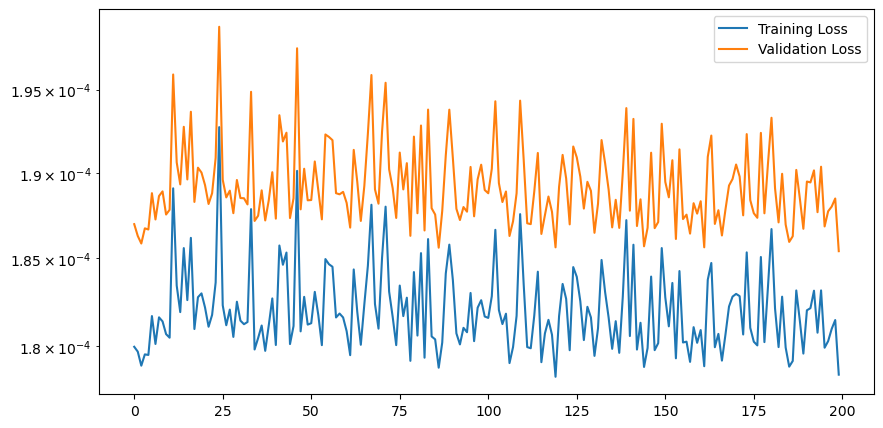

In [110]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [98]:
# data_file_path = '../data/data_dict_' + str(40) + '.npy'
        
# # Check if the file exists before trying to load it
# if os.path.exists(data_file_path):
#     data_dict = np.load(data_file_path, allow_pickle=True).item()
#     x_traj_test1, y_traj_test1, u_traj_test1 = build_dataset(data_dict)
# else:
#     print(f"File not found: {data_file_path}")


In [99]:
x_dataset_scaled = [scaler_x.transform(x) for x in x_dataset]
u_dataset_scaled = [scaler_u.transform(u) for u in u_dataset]

In [ ]:
# x_traj_test_scaled = scaler_x.transform(np.array(x_traj_test1))
# u_traj_test_scaled = scaler_u.transform(np.array(u_traj_test1))

In [ ]:
para_k = model_koopman.Para_k

In [ ]:
import torch

def koopman_predict(initial_data, u_data, steps, model_psi, model_inv_psi, para_k):
    data_traj = []
    
    initial_data_tensor = torch.tensor(initial_data, dtype=torch.float32).reshape((1, -1))
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    
    data_traj.append(initial_data_tensor)
    psi_x = model_psi(initial_data_tensor)
    psi_x_expanded = psi_x.unsqueeze(1)
    
    for step in range(steps):
        u = u_data_tensor[step,:].reshape((1, -1))
        psi_y_expanded = torch.bmm(psi_x_expanded, para_k(u))
        psi_y = psi_y_expanded.squeeze(1)
        data_traj.append(model_inv_psi(psi_y).detach().numpy())
        psi_x_expanded = psi_y_expanded

    return data_traj


In [ ]:
steps = 50

In [ ]:
import numpy as np
import torch

pred_data_traj = []
for x, u in zip(x_dataset_scaled, u_dataset_scaled):
    x_pred_scaled_traj = koopman_predict(x[0, :], u, steps, model_psi, model_inv_psi, para_k)
    
    x_pred_scaled = np.concatenate(x_pred_scaled_traj, axis=0)
    
    x_pred = scaler_x.inverse_transform(x_pred_scaled)
    pred_data_traj.append(x_pred)

In [ ]:
errors = [pred_data_traj[i] - x_dataset[i][:(steps+1), :] for i in range(len(pred_data_traj))]

# Calculate the norm of the error for each element
error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

# Calculate the norm of the original data for each element
data_norms = [np.linalg.norm(x_dataset[i][:(steps+1), :]) for i in range(len(x_dataset))]


# Calculate the ratio of the error norm to the data norm for each element
relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))]

# Calculate the mean and standard deviation of the relative errors for each element
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)

In [ ]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [ ]:
np.mean(domain_relative_error)

0.8657868189791724

In [ ]:
np.std(domain_relative_error)

0.03726819048143218

In [83]:
err_nonlinear_train = scaler_x.inverse_transform(err1_train_scaled) - scaler_x.inverse_transform(model_predict(x_train, u_train).detach().numpy())
err_nonlinear_train

array([[-5.45081494e-04, -1.07787835e-04,  1.06153681e-05, ...,
         2.70699395e-06,  8.28149046e-05, -3.22807854e-04],
       [-4.50752591e-04, -4.41487246e-05,  7.90251759e-06, ...,
        -2.12880161e-06,  3.23730845e-05, -1.00296409e-04],
       [ 2.11978063e-04,  5.49466264e-05, -3.14907856e-06, ...,
         1.05299824e-04,  4.69668960e-05, -1.86820766e-04],
       ...,
       [-4.39620381e-04, -1.18889219e-04,  9.51397031e-06, ...,
        -7.39785062e-05, -1.85392280e-05,  3.79946247e-04],
       [ 2.50725033e-04, -1.56809271e-05, -6.97127456e-06, ...,
        -6.00988437e-05, -3.58930875e-05,  2.79370482e-04],
       [ 1.89238165e-04, -1.73594501e-05, -9.49671691e-07, ...,
        -3.46751832e-06, -2.48408056e-05,  1.86365845e-04]])

In [84]:
err_nonlinear_test = scaler_x.inverse_transform(err1_test_scaled) - scaler_x.inverse_transform(model_predict(x_test, u_test).detach().numpy())
err_nonlinear_test

array([[-7.50837276e-05, -1.99841169e-05,  7.04919926e-07, ...,
         4.67295820e-05,  8.95752625e-05, -4.76785009e-04],
       [ 8.05978871e-04,  7.39580163e-05, -1.55344408e-05, ...,
         1.65450795e-04,  1.72157594e-04, -1.03275570e-03],
       [-3.29240893e-04, -4.57974015e-05,  7.86083926e-06, ...,
         8.55641362e-06,  4.42384552e-05, -5.40633298e-05],
       ...,
       [ 7.17917887e-05,  1.76112524e-05, -3.32844724e-06, ...,
        -4.09019754e-05, -2.93420109e-05,  2.13556890e-04],
       [ 6.27027341e-04,  7.84728212e-05, -1.18211035e-05, ...,
         4.88438103e-05, -5.87337685e-06, -9.54782346e-06],
       [-6.74677568e-04, -8.83607538e-05,  1.26971794e-05, ...,
        -2.09159881e-05,  3.09582219e-05, -9.25311840e-05]])

## Nonlinear Correction

In [100]:
scaler_e = StandardScaler().fit(err_nonlinear_train)
err_nonlinear_train_scaled = scaler_e.transform(err_nonlinear_train)
err_nonlinear_test_scaled = scaler_e.transform(err_nonlinear_test)
err_nonlinear_train_scaled = torch.tensor(err_nonlinear_train_scaled, dtype=torch.float32)
err_nonlinear_test_scaled = torch.tensor(err_nonlinear_test_scaled, dtype=torch.float32)


In [101]:
err_nonlinear_train_scaled

tensor([[-0.9515, -1.2640,  1.0486,  ...,  0.0544,  1.3378, -1.0670],
        [-0.7678, -0.4645,  0.7605,  ..., -0.0171,  0.5249, -0.3544],
        [ 0.5231,  0.7804, -0.4135,  ...,  1.5723,  0.7601, -0.6315],
        ...,
        [-0.7461, -1.4034,  0.9316,  ..., -1.0801, -0.2956,  1.1835],
        [ 0.5986, -0.1069, -0.8195,  ..., -0.8747, -0.5752,  0.8614],
        [ 0.4788, -0.1280, -0.1799,  ..., -0.0369, -0.3971,  0.5636]])

In [102]:
n_input = x_data.shape[1]
layer_sizes_dic = [64, 64, 128]
layer_sizes_m = [64, 128, 64, 64]

n_psi_train = 128
u_dim = 3

In [88]:
# model_correction = BuildNonlinearModel(n_input, layer_sizes_dic, layer_sizes_m, n_psi_train, u_dim)

In [103]:
# Initialize a list to store the loss values
train_losses_2 = []
val_losses_2 = []

# # Create a dataset
dataset_2 = TensorDataset(x_train, err_nonlinear_train_scaled, u_train)

# Create a data loader
data_loader_2 = DataLoader(dataset_2, batch_size=64, shuffle=True)


# Define the optimizer
optimizer_2 = Adam(list(model_correction.parameters()), lr=0.00001)

mse_loss = nn.MSELoss()

lambda_1 = 1.0
lambda_2 = 1.0
lambda_3 = 1.0

# Training process

for step in range(600):
    for x_batch, y_batch, u_batch in data_loader_2:
        # Forward propagation
        optimizer_2.zero_grad()
        
        y_pred_batch = model_correction(x_batch, u_batch)
        
        loss = mse_loss(y_pred_batch, y_batch)

        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
    
    # Training Loss
    y_pred = model_correction(x_train, u_train)
        
    loss = mse_loss(y_pred, err_nonlinear_train_scaled)
    
    train_losses_2.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')


    # Test the model
    with torch.no_grad():
        y_pred = model_correction(x_test, u_test)      
        loss = mse_loss(y_pred, err_nonlinear_test_scaled)        
        val_losses_2.append(loss.item())

    
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.2553962469100952
Epoch: 0, Loss: 0.21821685135364532
Epoch: 1, Loss: 0.2537460923194885
Epoch: 1, Loss: 0.21733739972114563
Epoch: 2, Loss: 0.253505140542984
Epoch: 2, Loss: 0.2172362059354782
Epoch: 3, Loss: 0.25260019302368164
Epoch: 3, Loss: 0.21688848733901978
Epoch: 4, Loss: 0.25263386964797974
Epoch: 4, Loss: 0.21663595736026764
Epoch: 5, Loss: 0.25178098678588867
Epoch: 5, Loss: 0.2165675163269043
Epoch: 6, Loss: 0.25118952989578247
Epoch: 6, Loss: 0.21644431352615356
Epoch: 7, Loss: 0.25363484025001526
Epoch: 7, Loss: 0.21673105657100677
Epoch: 8, Loss: 0.25069597363471985
Epoch: 8, Loss: 0.2161809355020523
Epoch: 9, Loss: 0.25031837821006775
Epoch: 9, Loss: 0.21607288718223572
Epoch: 10, Loss: 0.25041019916534424
Epoch: 10, Loss: 0.21596987545490265
Epoch: 11, Loss: 0.2501058578491211
Epoch: 11, Loss: 0.21621376276016235
Epoch: 12, Loss: 0.24972906708717346
Epoch: 12, Loss: 0.21588706970214844
Epoch: 13, Loss: 0.2493169605731964
Epoch: 13, Loss: 0.21560241281

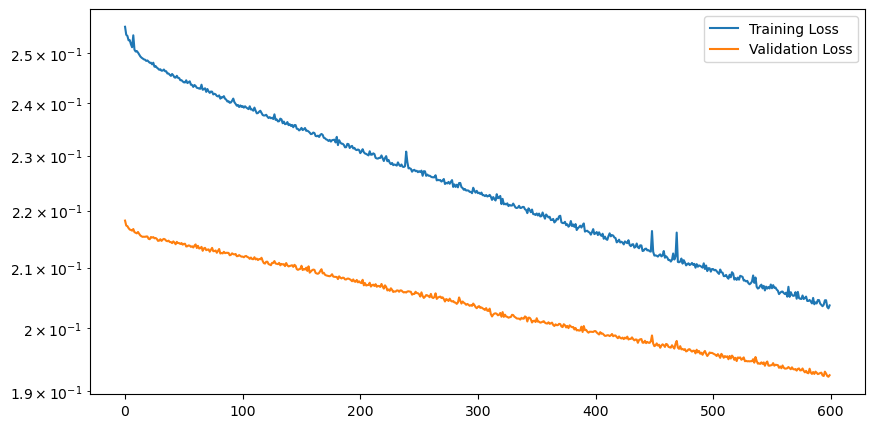

In [104]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [113]:
def Hybridpredictor(x0, u_data, steps, model_predict, model_correction, scaler_x, scaler_y1, scaler_y2, scaler_u):
    data_traj = []
    
    x0 = x0.reshape((1,-1))
    data_traj.append(x0)
    
    x0_scaled = scaler_x.transform(x0)
    u_data_scaled = scaler_u.transform(u_data)
    
    x = torch.tensor(x0_scaled, dtype=torch.float32)
    u_data_scaled_tensor = torch.tensor(u_data_scaled, dtype=torch.float32)
    
    
    for step in range(steps):
        u = u_data_scaled_tensor[step:step+1, :]
#         print(u)
        y1_scaled = model_predict(x, u).detach().numpy()
        y2_scaled = model_correction(x, u).detach().numpy()
        y1 = scaler_y1.inverse_transform(y1_scaled)
        y2 = scaler_y2.inverse_transform(y2_scaled)
        y_np = y1 + y2
        data_traj.append(y_np)
        y_scaled = scaler_x.inverse_transform(y_np)
        x = torch.tensor(y_scaled, dtype=torch.float32)
    
    return data_traj

In [270]:
import numpy as np
import torch

steps = 50

pred_data_traj = []
for x, u in zip(x_dataset, u_dataset):
    x_pred_traj = Hybridpredictor(x[0, :], u, steps, model_predict, model_correction, scaler_x, scaler_x, scaler_e, scaler_u)
    
    x_pred = np.concatenate(x_pred_traj, axis=0)
    
    pred_data_traj.append(x_pred)

In [271]:
errors = [pred_data_traj[i] - x_dataset[i][:(steps+1), :] for i in range(len(pred_data_traj))]

# Calculate the norm of the error for each element
error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

# Calculate the norm of the original data for each element
data_norms = [np.linalg.norm(x_dataset[i][:(steps+1), :]) for i in range(len(x_dataset))]


# Calculate the ratio of the error norm to the data norm for each element
relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))]

# Calculate the mean and standard deviation of the relative errors for each element
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)

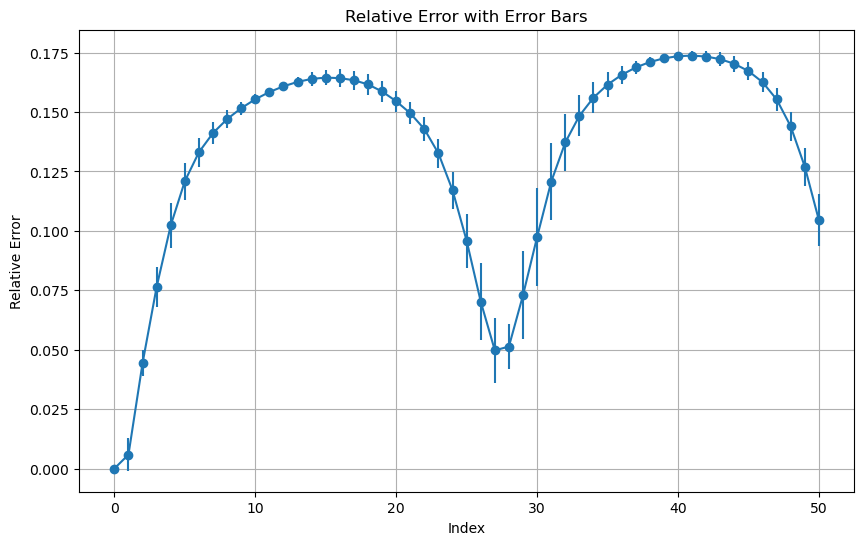

In [272]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps+1), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [273]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

print(np.mean(domain_relative_error))
print(np.std(domain_relative_error))

1.003281625668474
0.0053140134398373985


In [274]:
mean_relative_errors[1]

0.005872207351469011

In [111]:
steps = 1
x = x_dataset[0]
u = u_dataset[0]

In [114]:
diff_abs = []
for i in range(x_data.shape[0]):
    x = x_data[i:i+1, :]
    y = y_data[i:i+1, :]
    u = u_data[i:i+1, :]
#     print(u)
    x_pred_traj = Hybridpredictor(x[0,:], u, steps, model_predict, model_correction, scaler_x, scaler_x, scaler_e, scaler_u)
    diff_abs.append(np.abs(y.flatten()-x_pred_traj[1].flatten()))

In [115]:
diff_abs = np.concatenate(diff_abs)
diff_abs.shape

(50236497,)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 假设 diff_abs 是你的数据数组
# diff_abs = np.array([...])

# 计算密度
density = gaussian_kde(diff_abs)
xs = np.linspace(min(diff_abs), max(diff_abs), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()

# 绘制密度图
plt.plot(xs, density(xs))
plt.title('Density Function of diff_abs')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


KeyboardInterrupt: 

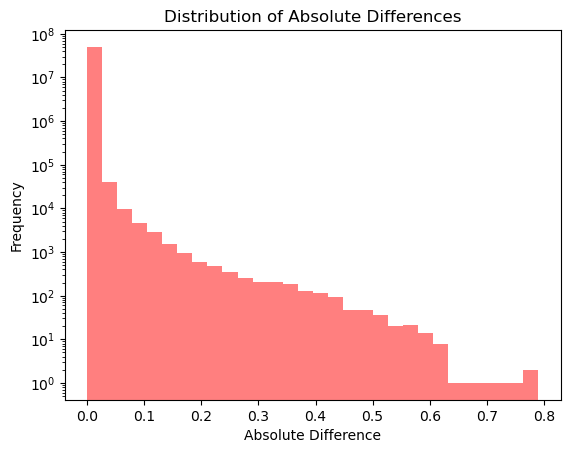

In [118]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(diff_abs.flatten(), bins=30, alpha=0.5, color='red')
plt.title('Distribution of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


In [287]:
np.max(diff_abs)

0.7912185661890667

In [261]:
torch.save(model_predict.state_dict(), 'model_predict_weights.pth')
torch.save(model_correction.state_dict(), 'model_correction_weights.pth')